In [29]:
# Importamos las librerias necesarias

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Obtención de los datos

In [30]:
data_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

SP500Companies = pd.read_html(data_url)[0]

# Renombramos las columnas por comodidad
SP500Companies.rename(columns={'GICS Sector': 'Sector'}, inplace=True)

# Renombramos algunos simbolos para evitar problemas a futuro
SP500Companies['Symbol'] = SP500Companies['Symbol'].str.strip().replace({'BF.B': 'BF-B', 'BRK.B': 'BRK-B'})

# Definir el rango de fechas
start_date = '2000-01-01'
end_date = '2023-02-01'

# Crear un DataFrame vacío para almacenar los datos
sp500_data = pd.DataFrame()

# Iterar a través de cada compañia del SP500 y agregamos los datos al Dataframe creado
for _, company in SP500Companies.iterrows():
    symbol = company['Symbol']
    sector = company['Sector']
    # Descargamos los datos de cada compañia
    data = yf.download(symbol, start=start_date, end=end_date)['Adj Close']
    if len(data) > 0:
        data = data.to_frame()
        data.loc[:, 'Symbol'] = symbol
        data.loc[:, 'Sector'] = sector
        sp500_data = pd.concat([sp500_data, data], axis=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [31]:
# Obteniendo datos solo del SP500
sp500_index = yf.download('^GSPC', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [32]:
#Visualizamos ambos dataframes dataframes

sp500_data.head(5)

,Adj Close,Symbol,Sector
Date,,,
2000-01-03,25.525517,MMM,Industrials
2000-01-04,24.511259,MMM,Industrials
2000-01-05,25.221239,MMM,Industrials
2000-01-06,27.249758,MMM,Industrials
2000-01-07,27.790680,MMM,Industrials


In [33]:
sp500_index.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [34]:
# Guardo ambos datasets en archivos csv
sp500_index.to_csv('datasets/GSPC.csv')
sp500_data.to_csv('datasets/companies.csv')

In [35]:
# Abrimos el dataset de GSPC
sp500 = pd.read_csv('datasets/GSPC.csv')

# Cambiamos su indice a date
sp500.set_index('Date', inplace=True)

In [36]:
# index este en formato fecha
sp500.index= pd.to_datetime(sp500.index)

Agrego columnas que serviran en el analisis.

In [37]:
# Nombre del dia
sp500['Day Name'] = sp500.index.day_name()

# Tasa del retorno activo

sp500['Daily Return'] = sp500['Adj Close'].pct_change()

# EDA

### EDA - GSPC

Valores duplicados

In [38]:
# reabrimos el csv 

sp500 = pd.read_csv('datasets/GSPC.csv')

# Hacemos que el indice sea la columna date y nos aseguremos que este en formato fecha
sp500.set_index('Date', inplace=True)
sp500.index = pd.to_datetime(sp500.index)

In [39]:
sp500[sp500.duplicated()] 
# No hay valores duplicados

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


Valores faltantes

In [40]:
# Veamos los valores nulos

sp500.isnull().sum().sort_values(ascending=False)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Graficamos la tendencia del indice a lo largo del tiempo

In [41]:
import statsmodels.api as sm
import plotly.graph_objs as go

In [42]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
sp500_index_ciclo, sp500Indice_tend = sm.tsa.filters.hpfilter(sp500_index['Adj Close'])
sp500_index['tend'] = sp500Indice_tend


fig = go.Figure(data=go.Scatter(x=sp500_index.index, y=sp500_index['tend']))
fig.update_layout(title='S&P 500 Index',
                  xaxis_title='Date',
                  yaxis_title='tend Price', 
                  plot_bgcolor='black',
                  xaxis=dict(linecolor='white', showgrid=False),
                  yaxis=dict(linecolor='white', showgrid=False),)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(label="All", step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    yaxis=dict(
        fixedrange=False
    ),
    margin=dict(l=50, r=50, b=50, t=50, pad=4),
    height=600,
)

fig.show()

In [43]:
#Guardamos
sp500.to_csv('datasets/GSPC.csv')

In [61]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


## Sectores

In [45]:
import numpy as np

In [46]:
SP500Companies = pd.read_csv('datasets/companies.csv')

# Setteamos como indice la columna Date y nos aseguremos que tenga sea reconocida como fecha
SP500Companies.set_index('Date', inplace=True)
SP500Companies.index = pd.to_datetime(SP500Companies.index)


In [47]:
#Agrego columnas
SP500Companies['Day Name'] = SP500Companies.index.day_name()
SP500Companies['Daily Return']=SP500Companies['Adj Close'].pct_change() 

In [48]:
#Visualizo
SP500Companies.head()

,Adj Close,Symbol,Sector,Day Name,Daily Return
Date,,,,,
2000-01-03,25.525517,MMM,Industrials,Monday,NaN
2000-01-04,24.511259,MMM,Industrials,Tuesday,-0.039735
2000-01-05,25.221239,MMM,Industrials,Wednesday,0.028965
2000-01-06,27.249758,MMM,Industrials,Thursday,0.080429
2000-01-07,27.790680,MMM,Industrials,Friday,0.019851


Valores duplicados

In [49]:
SP500Companies[SP500Companies.duplicated()]

,Adj Close,Symbol,Sector,Day Name,Daily Return
Date,,,,,
2002-09-13,3.488167,AOS,Industrials,Friday,0.000000
2002-12-13,12.841617,ACN,Information Technology,Friday,-0.006764
2005-03-24,17.782940,ACN,Information Technology,Thursday,0.004115
2000-09-21,1.071276,ATVI,Communication Services,Thursday,0.000000
2010-06-21,10.370570,ATVI,Communication Services,Monday,0.006103
...,...,...,...,...,...
2000-03-24,7.246358,XEL,Utilities,Friday,0.003322
2000-07-10,8.302968,XEL,Utilities,Monday,0.011905
2000-11-27,10.534280,XEL,Utilities,Monday,-0.016471


No elimino duplicados porque todos son de distintas fechas, estaria eliminando datos relevantes del dataset

Valores nulos

In [50]:
SP500Companies.isna().sum().sort_values(ascending=False)

Daily Return    1
Adj Close       0
Symbol          0
Sector          0
Day Name        0
dtype: int64

No hay necesidad de eliminar el dato faltante , asique decido rellenarlo por el valor 0

In [52]:
SP500Companies.fillna(0)

,Adj Close,Symbol,Sector,Day Name,Daily Return
Date,,,,,
2000-01-03,25.525517,MMM,Industrials,Monday,0.000000
2000-01-04,24.511259,MMM,Industrials,Tuesday,-0.039735
2000-01-05,25.221239,MMM,Industrials,Wednesday,0.028965
2000-01-06,27.249758,MMM,Industrials,Thursday,0.080429
2000-01-07,27.790680,MMM,Industrials,Friday,0.019851
...,...,...,...,...,...
2023-01-25,165.509995,ZTS,Health Care,Wednesday,-0.002291
2023-01-26,168.240005,ZTS,Health Care,Thursday,0.016495
2023-01-27,165.179993,ZTS,Health Care,Friday,-0.018188


In [53]:
# Guardamos nuestro dataset
SP500Companies.to_csv('datasets/companies.csv')

### Empreas por sector

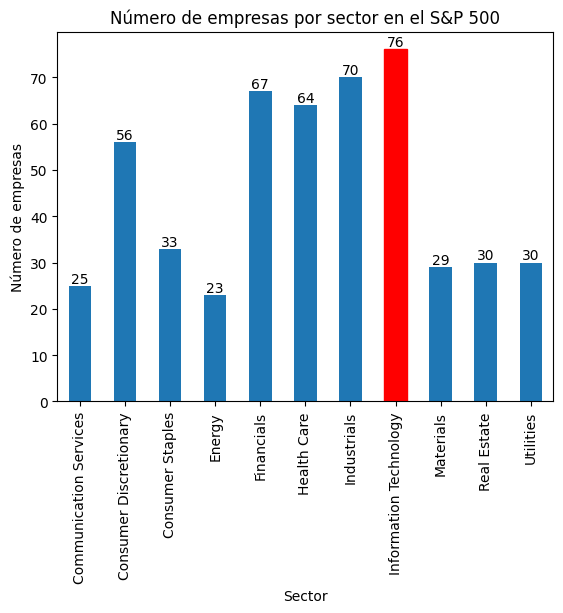

In [54]:
empresas_por_sector = SP500Companies.groupby('Sector')['Symbol'].nunique()
empresas_por_sector

empresas_por_sector.plot(kind='bar')

# Agregar etiquetas a las barras
for i, v in enumerate(empresas_por_sector.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.title('Número de empresas por sector en el S&P 500')
plt.xlabel('Sector')
plt.ylabel('Número de empresas')

# Resaltar la barra más alta
max_index = np.argmax(empresas_por_sector)
plt.gca().patches[max_index].set_color('red')

plt.show()

### Rentabilidad anual

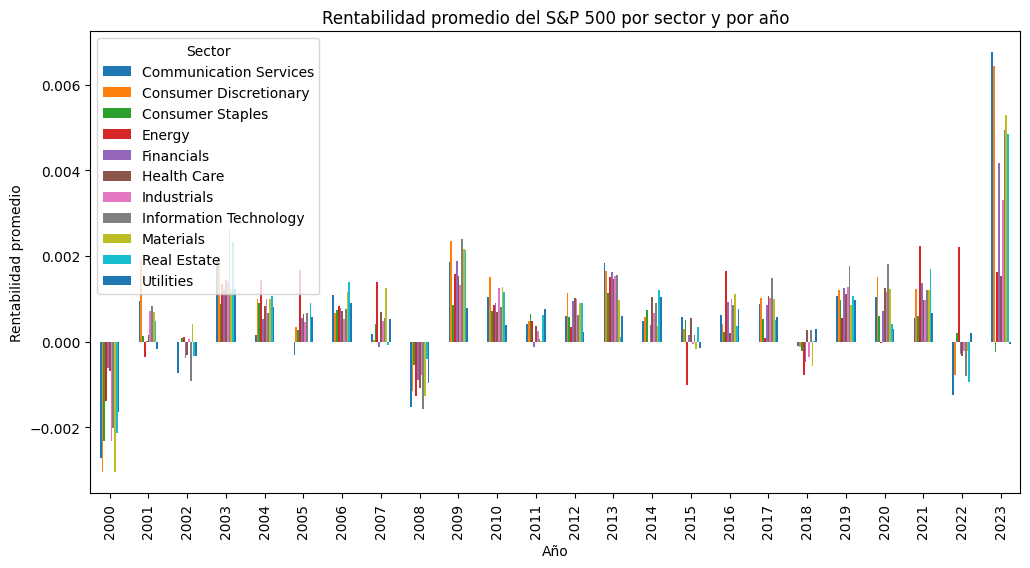

In [56]:
# Agrupar los datos por sector y por año, y calcular la rentabilidad promedio
returns_by_sector_year = SP500Companies.groupby(['Sector', SP500Companies.index.year])['Daily Return'].mean()

# Reorganizar los datos para que cada sector sea una columna y cada año sea un índice
returns_by_sector_year = returns_by_sector_year.unstack('Sector')

# Graficar los resultados
returns_by_sector_year.plot(kind='bar', figsize=(12,6))
plt.xlabel('Año')
plt.ylabel('Rentabilidad promedio')
plt.title('Rentabilidad promedio del S&P 500 por sector y por año')
plt.show()

### Retorno 

In [58]:
retornoTotal = (SP500Companies.groupby('Symbol')['Adj Close'].last() - SP500Companies.groupby('Symbol')['Adj Close'].first()) / SP500Companies.groupby('Symbol')['Adj Close'].first()
# Seleccionar las diez primeras compañías con el mayor retorno total
retornoTotalTop10 = retornoTotal.nlargest(10)
retornoTotalTop10

Symbol
MNST    1157.452406
ODFL     344.126021
NFLX     294.763460
TSCO     265.555529
NVDA     217.279032
AAPL     168.365945
ISRG     120.162185
IDXX     118.657588
NVR      112.181208
TSLA     107.760967
Name: Adj Close, dtype: float64

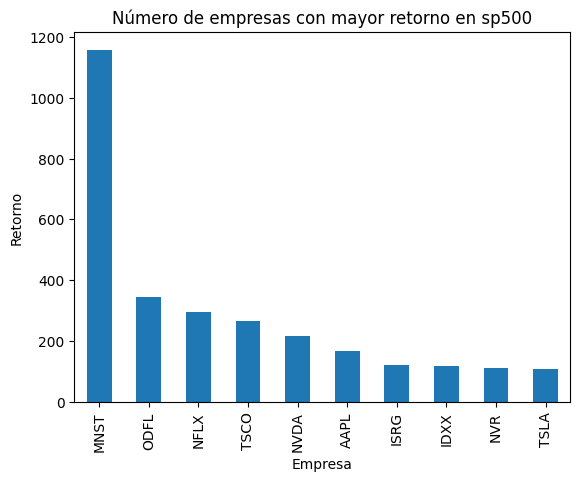

In [60]:
#Grafico
retornoTotalTop10.plot(kind='bar')

    
plt.title('Número de empresas con mayor retorno en sp500')
plt.xlabel('Empresa')
plt.ylabel('Retorno')



plt.show()